In [1]:
import seaborn as sns
from tqdm import tqdm

import matplotlib.pyplot as plt
from clustering import *
from utils import plot


In [2]:
#df of log returns
df_60m = pd.read_parquet("data/clean/60m/data_clean_60m_log_ret.parquet")

In [3]:
df_60m

,SBUX,ISRG,KIM,QCOM,GL,WFC,CRM,STT,WMT,AON,...,UAA,EFX,HII,APD,O,DPZ,ETN,CNC,TFC,GE
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-29 11:30:00-05:00,-0.005794,0.001470,0.000000,0.000227,0.000283,-0.000420,0.003335,-0.004240,-0.001795,-0.000299,...,-0.009843,-0.000065,-0.023320,-0.000717,0.001400,0.004457,-0.001955,-0.002971,-0.001282,-0.002705
2020-01-29 12:30:00-05:00,0.002553,0.001814,0.000000,0.003228,0.001791,0.001153,0.000818,-0.002826,0.000684,0.000184,...,-0.003303,0.000967,0.004322,0.002615,-0.001253,0.000194,-0.000103,0.000381,-0.002650,-0.001162
2020-01-29 13:30:00-05:00,0.009173,0.000075,-0.003466,-0.001075,0.000000,-0.000419,0.001580,0.001755,-0.001940,0.000735,...,0.000000,0.002446,0.001890,-0.001159,-0.001867,0.001695,0.000772,0.003502,-0.008452,0.002322
2020-01-29 14:30:00-05:00,0.001882,-0.003881,-0.001986,-0.000057,-0.002357,-0.005783,-0.004694,-0.007300,-0.001858,-0.002344,...,-0.003551,-0.004704,-0.000491,0.000970,-0.000893,0.000245,-0.000103,-0.005181,-0.004902,-0.002710
2020-01-29 15:30:00-05:00,-0.005391,-0.005675,-0.002987,-0.001189,0.000189,-0.003063,-0.005651,-0.002555,-0.005050,-0.003411,...,-0.004039,-0.002781,-0.001399,-0.000295,-0.002301,-0.002449,-0.002423,-0.003980,-0.001299,0.003096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-26 14:30:00-05:00,-0.025384,-0.031611,-0.026317,-0.034022,-0.014465,-0.013396,-0.024054,-0.026997,-0.011085,-0.017708,...,-0.030747,-0.034664,-0.018608,-0.017182,-0.023925,-0.020746,-0.017236,-0.025104,-0.022172,-0.023210
2022-01-26 15:30:00-05:00,0.004773,0.001364,0.000833,0.001832,0.000390,0.008705,-0.004510,0.007985,0.001549,0.003709,...,0.000000,0.009939,0.003452,0.001742,0.000442,-0.008430,0.001013,0.006801,0.013776,0.007311
2022-01-27 09:30:00-05:00,0.004802,0.007827,0.003325,-0.004561,0.004908,0.008264,0.040331,0.010234,0.016810,-0.002134,...,0.015083,0.002381,0.003067,0.008056,0.010111,0.005730,0.007627,0.016213,0.006027,0.012363


In [19]:
#Download tickers

tickers = pd.read_csv('tickers/s&p.csv')
tickers.sort_values(by="Symbol", inplace=True)
tickers.reset_index(drop=True, inplace=True)

#Keep only tickers in df_60m
tickers = tickers.iloc[np.where(tickers["Symbol"].isin(df_60m.columns))]
tickers.reset_index(drop=True, inplace=True)
tickers

,Symbol,Name,Sector
0,A,Agilent Technologies,Health Care
1,AAL,American Airlines Group,Industrials
2,AAP,Advance Auto Parts,Consumer Discretionary
3,AAPL,Apple,Information Technology
4,ABBV,AbbVie,Health Care
...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary
499,ZBH,Zimmer Biomet,Health Care
500,ZBRA,Zebra Technologies,Information Technology
501,ZION,Zions Bancorp,Financials


In [5]:
#Order df_60m by ticker name

df_60m = df_60m[tickers["Symbol"]]


In [6]:
#Rolling clustering for 60m dataset


#Cluster tickers

#Compute T=3*N
N = df_60m.shape[1]
T = 3 * N

#Number of windows possible
lag_max = df_60m.shape[0] - T
liste = RolledCluster(df_60m, T, "louvain_cluster/asset", False, False, lag_max)

In [7]:
liste_cluster = dask.compute(dask.compute(liste))[0][0]
liste_cluster

[      Cluster
 A           0
 AAL         1
 AAP         2
 AAPL        3
 ABBV        4
 ...       ...
 YUM       498
 ZBH       499
 ZBRA      500
 ZION      501
 ZTS       502
 
 [503 rows x 1 columns],
       Cluster
 A           0
 AAL         1
 AAP         2
 AAPL        3
 ABBV        4
 ...       ...
 YUM       498
 ZBH       499
 ZBRA      500
 ZION      501
 ZTS       502
 
 [503 rows x 1 columns],
       Cluster
 A           0
 AAL         1
 AAP         2
 AAPL        3
 ABBV        4
 ...       ...
 YUM       498
 ZBH       499
 ZBRA      500
 ZION      501
 ZTS       502
 
 [503 rows x 1 columns],
       Cluster
 A           0
 AAL         1
 AAP         2
 AAPL        3
 ABBV        4
 ...       ...
 YUM       498
 ZBH       499
 ZBRA      500
 ZION      501
 ZTS       502
 
 [503 rows x 1 columns],
       Cluster
 A           0
 AAL         1
 AAP         2
 AAPL        3
 ABBV        4
 ...       ...
 YUM       498
 ZBH       499
 ZBRA      500
 ZION      501
 ZTS   

In [8]:
number_of_clusters = []
for element in tqdm(liste_cluster):
    number_of_clusters.append(element["Cluster"].unique().max() + 1)

#Create dataframe for plotting reasons
df_plot_clusters = pd.DataFrame(number_of_clusters)
df_plot_clusters["Datetime"] = df_60m[df_60m.index > "2020-12-04 11:30:00-05:00"].index
df_plot_clusters.rename(columns={0: "Clusters", "Datetime": "Datetime"}, inplace=True)
df_plot_clusters

100%|██████████| 2010/2010 [00:00<00:00, 3892.13it/s]


,Clusters,Datetime
0,503,2020-12-04 12:30:00-05:00
1,503,2020-12-04 13:30:00-05:00
2,503,2020-12-04 14:30:00-05:00
3,503,2020-12-04 15:30:00-05:00
4,503,2020-12-07 09:30:00-05:00
...,...,...
2005,3,2022-01-26 14:30:00-05:00
2006,3,2022-01-26 15:30:00-05:00
2007,3,2022-01-27 09:30:00-05:00
2008,3,2022-01-27 10:30:00-05:00


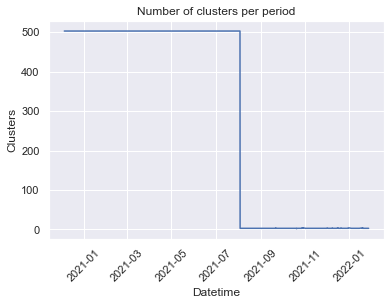

In [9]:
plot(df_plot_clusters, x="Datetime", y="Clusters", hue=None, title='Number of clusters per period', x_label=None,
     y_label=None, save_name="Plot_number_clusters_assets")


In [10]:
#Get position of drop

cut = 0
while number_of_clusters[cut] > 10:
    cut = cut + 1

#This gives time from which we have a reasonable amount of clusters
df_60m.index[cut+T]

Timestamp('2021-08-03 09:30:00-0400', tz='America/New_York')

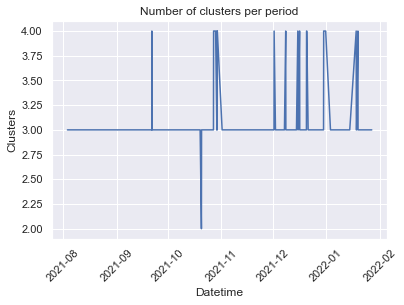

In [11]:
plot(df_plot_clusters[cut:], x="Datetime", y="Clusters", hue=None, title='Number of clusters per period',
     x_label=None, y_label=None, save_name=None)



In [12]:
#Add column for ARI measure

ARI = RolledARI(liste_cluster)

#Insert a value for ARI at time 0 for plotting
ARI.insert(0, 1)
df_plot_clusters["ARI"] = ARI

df_plot_clusters

100%|██████████| 2009/2009 [00:02<00:00, 687.87it/s]


,Clusters,Datetime,ARI
0,503,2020-12-04 12:30:00-05:00,1.000000
1,503,2020-12-04 13:30:00-05:00,1.000000
2,503,2020-12-04 14:30:00-05:00,1.000000
3,503,2020-12-04 15:30:00-05:00,1.000000
4,503,2020-12-07 09:30:00-05:00,1.000000
...,...,...,...
2005,3,2022-01-26 14:30:00-05:00,0.977469
2006,3,2022-01-26 15:30:00-05:00,0.981822
2007,3,2022-01-27 09:30:00-05:00,0.977019
2008,3,2022-01-27 10:30:00-05:00,0.982472


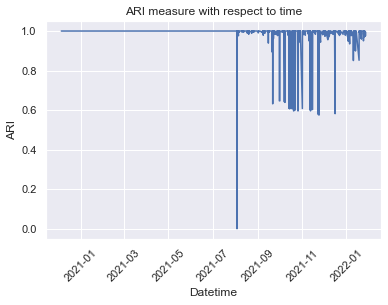

In [13]:
plot(df_plot_clusters, x="Datetime", y="ARI", hue=None, title='ARI measure with respect to time', x_label=None,
     y_label=None, save_name="Plot_ARI_assets")



In [14]:
#Relabeled clusters but only from cut moment
new_liste=liste_cluster[cut:]

#Define a new list of clusters relabeled
relabeled=map_clusters(new_liste)

In [15]:
relabeled

[      Cluster
 A           0
 AAL         2
 AAP         2
 AAPL        0
 ABBV        1
 ...       ...
 YUM         1
 ZBH         2
 ZBRA        0
 ZION        2
 ZTS         0
 
 [503 rows x 1 columns],
       Cluster
 A           0
 AAL         2
 AAP         2
 AAPL        0
 ABBV        1
 ...       ...
 YUM         1
 ZBH         2
 ZBRA        0
 ZION        2
 ZTS         0
 
 [503 rows x 1 columns],
       Cluster
 A           0
 AAL         2
 AAP         2
 AAPL        0
 ABBV        1
 ...       ...
 YUM         1
 ZBH         2
 ZBRA        0
 ZION        2
 ZTS         0
 
 [503 rows x 1 columns],
       Cluster
 A           0
 AAL         2
 AAP         2
 AAPL        0
 ABBV        1
 ...       ...
 YUM         1
 ZBH         2
 ZBRA        0
 ZION        2
 ZTS         0
 
 [503 rows x 1 columns],
       Cluster
 A           0
 AAL         2
 AAP         2
 AAPL        0
 ABBV        1
 ...       ...
 YUM         1
 ZBH         2
 ZBRA        0
 ZION        2
 ZTS   

In [16]:
#create dataframe of composition of clusters of size k
def composition_matrix(tickers, liste_cluster, axis=0, threshold=1):
    
    #Group tickers by sector
    grouped_tickers_sector= tickers.groupby("Sector")
    
    #Get number of rows to be the maximum number a cluster have
    liste_max=[]
    for element in liste_cluster:
        liste_max.append(element["Cluster"].max())
    
    nb_clusters_all=max(liste_max)+1
    
    
    #Create dataframe
    df = pd.DataFrame(np.zeros((nb_clusters_all, len(tickers["Sector"].unique()))), index=range(nb_clusters_all),
                      columns=tickers["Sector"].unique())

    #loop over each cluster
    for cluster in tqdm(liste_cluster):
        
        #Get the number value of clusters
        value_cluster=cluster["Cluster"].unique()
        
        #Group tickers by cluster belonging
        grouped_cluster=cluster.groupby("Cluster")
        
        
        #Loop over each value of cluster
        for i in value_cluster:
            
            
            #Get corresponding group of tickers
            
            tickers_in_i = grouped_cluster.get_group(i)
            
            #Loop for each sector
            for sector in tickers["Sector"].unique():
                

                #Number of tickers in cluster i belonging to sector
                
                matching_tickers=len(np.where(grouped_tickers_sector.get_group(sector)["Symbol"].isin(grouped_cluster.get_group(i).index))[0])
                
                #Add this number of matching tickers to dataframe at right place
                
                df[sector][i]=df[sector][i]+matching_tickers
    
    #create percentages by column of by line
    if axis == 0:
        for index in range(k):
            df.iloc[index] = df.iloc[index] / df.iloc[index].sum() * 100
    else:
        df = df / df.sum(axis=0) * 100

        
    #Take out lines with all values under threshold for visibility
    drop_index= np.where(((df>=threshold)*df).sum(axis=1)==0)[0]
    df.drop(drop_index, axis=0, inplace=True)
    
    #Round number with 1 decimal
    df = df.round(decimals=1)
    return (df)


In [17]:
df = composition_matrix(tickers, relabeled, axis=1, threshold=2)
df

100%|██████████| 860/860 [00:21<00:00, 40.62it/s]


,Health Care,Industrials,Consumer Discretionary,Information Technology,Consumer Staples,Utilities,Financials,Materials,Real Estate,Energy,Communication Services
0,59.9,21.0,33.7,79.5,24.0,22.9,14.8,13.6,19.2,0.4,39.7
1,11.2,4.3,2.2,2.9,18.4,26.0,3.1,2.1,8.2,0.0,2.1
2,5.4,63.4,59.9,13.5,20.6,0.3,76.2,72.6,39.0,99.6,50.5
11,5.4,2.4,0.9,1.2,8.3,11.5,1.5,2.5,7.3,0.0,1.9
12,3.3,1.5,0.6,0.6,4.8,6.9,0.9,1.5,4.6,0.0,1.1
15,2.0,1.0,0.4,0.5,3.2,4.5,0.6,1.0,3.1,0.0,0.7
19,10.1,5.0,1.8,1.2,16.9,22.0,2.2,5.5,13.0,0.0,3.3


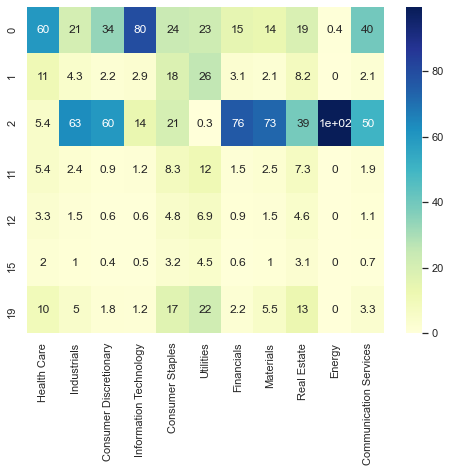

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df, annot=True, cmap="YlGnBu")
plt.savefig("plots/composition_matrix.svg", format="svg")